<a href="https://colab.research.google.com/github/kaktys21/python-for-DataScience_geekbrains2/blob/main/EDEpishev_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



##Импорты необходимых библиотек

In [940]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [941]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import catboost as cb

import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import probplot

%matplotlib inline

In [942]:
import warnings
warnings.simplefilter('ignore')

##Пути к файлам

In [943]:
TEST_PATH = 'https://raw.githubusercontent.com/kaktys21/python-for-DataScience_geekbrains2/main/course_project/course_project_test.csv'
TRAIN_PATH = 'https://raw.githubusercontent.com/kaktys21/python-for-DataScience_geekbrains2/main/course_project/course_project_train.csv'

##Дополнительные функции

In [944]:
def describe_tables(target_name):

  '''Графики-таблички'''

  plt.figure(figsize=(20,8))
  ax1 = plt.subplot(121)
  ax1.set_xlabel(target_name)
  ax1.set_ylabel('Count')
  ax1.set_title(f'{target_name} distribution')
  df[target_name].hist()
  plt.subplot(122)
  probplot(df[target_name], dist='norm', plot=plt)

  plt.show()

def outlier_cutter(df, column_name, q=.95):
  
  '''Удаляет выбросы'''
  
  df.loc[df[column_name] > df[column_name].quantile(q), [column_name]] = df[column_name].median()
  return df

def nan_filler(df, column_name, filler=0):

  '''Заполняет пропуски'''
  
  df[column_name].fillna(filler, inplace=True)
  return df

def other_value_filler(df, column_name, filler, filler_type, null_filling_flag=0, null_filler=11):

  '''Замена значений в строках'''

  df[column_name] = df[column_name].map(filler).astype(filler_type)

  if null_filling_flag:
    df.loc[df[column_name].isnull(), 'Years in current job'] = null_filler

  return df

def years_of_credit_history(df, years=40):
  
  '''Замена 40+ стажа на 40'''

  df.loc[df['Years of Credit History'] > 40, ['Years of Credit History']] = 40
  return df

def current_loan_amount(df):
  
  df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
  df.loc[df['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
  df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean()
  return df

def credit_score(df):
  
  df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
  df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1
  df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
  df.loc[(df['Credit Score'] >= 750) & (df['Credit Score'] <= 800), 'Credit Score'] = 3
  df.loc[(df['Credit Score'] > 800), 'Credit Score'] = 4
  return df

##Обзор и заполнение данных

In [945]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [946]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [947]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [948]:
df['ID'] = df.index.tolist()

In [949]:
TARGET_NAME = 'Credit Default'

###Home Ownership

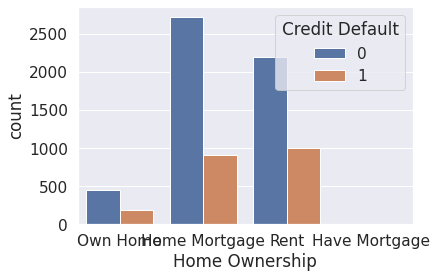

In [950]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [951]:
df = pd.concat([df.drop('Home Ownership', 1), pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

###Annual Income

In [952]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

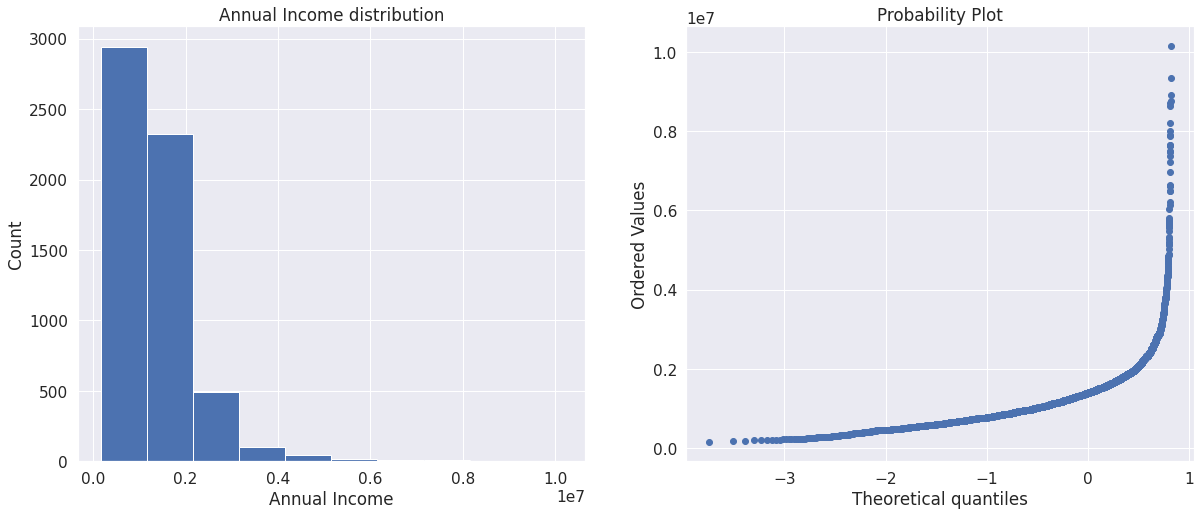

In [953]:
describe_tables('Annual Income')

In [954]:
# нули заполняем средним значнием

df = nan_filler(df, 'Annual Income', df['Annual Income'].mean())
df_test = nan_filler(df_test, 'Annual Income', df_test['Annual Income'].mean())

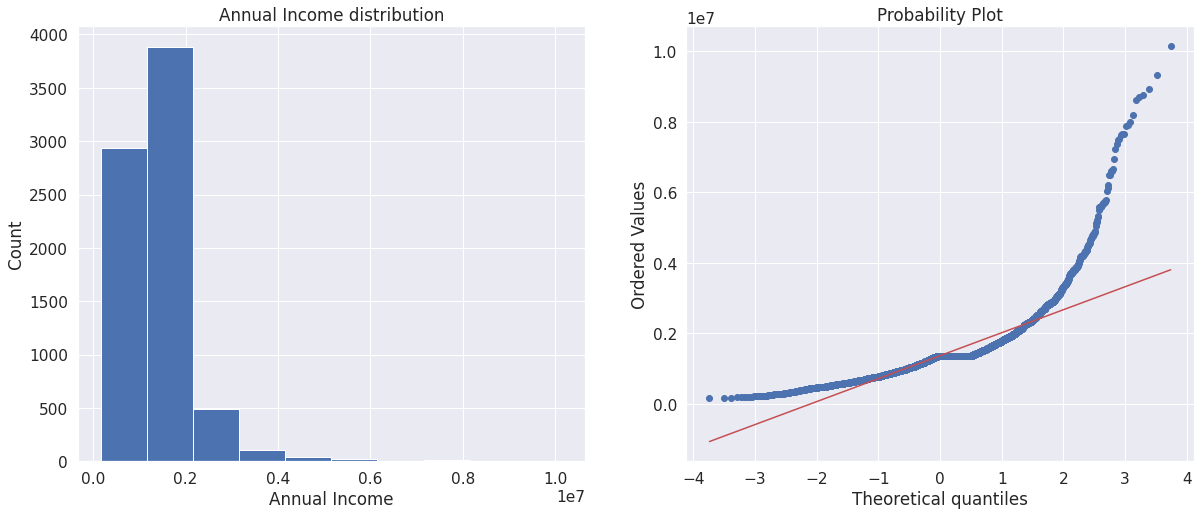

In [955]:
describe_tables('Annual Income')

In [956]:
# убираем выбросы

df = outlier_cutter(df, 'Annual Income', .99)
df_test = outlier_cutter(df_test, 'Annual Income', .99)

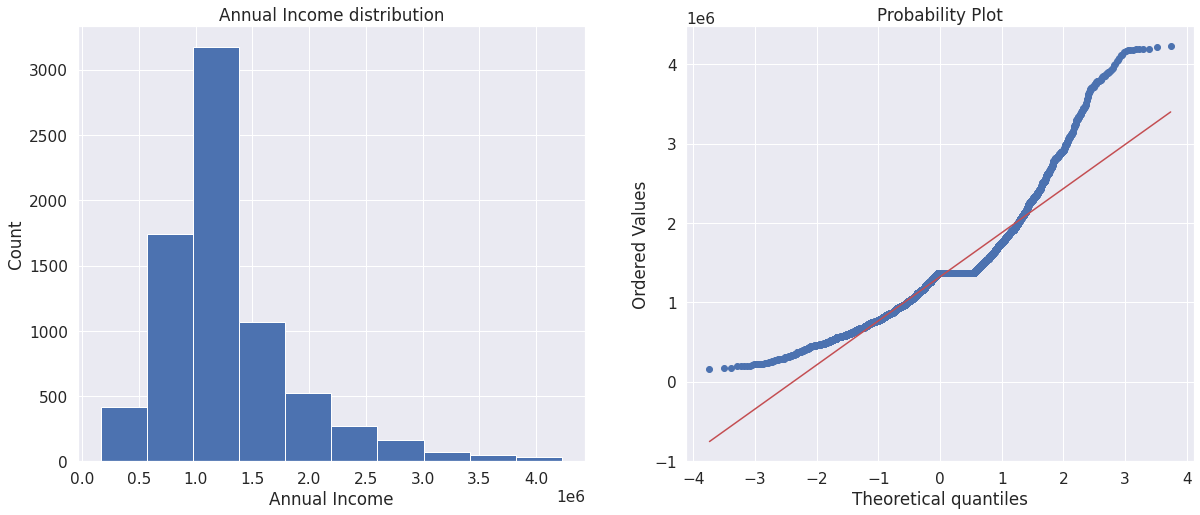

In [957]:
describe_tables('Annual Income')

###Years in current job

In [958]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

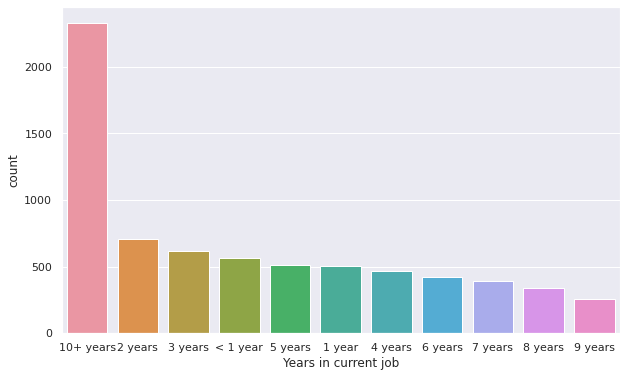

In [959]:
# смотрим распределение значений

sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df['Years in current job'], order = df['Years in current job'].value_counts().index)

In [960]:
# приводим к численным значниям

years_str_to_int = {'10+ years':'10', '9 years':'9','8 years':'8','7 years':'7','6 years':'6', 
                    '5 years':'5','4 years':'4','3 years':'3','2 years':'2','1 year':'1','< 1 year':'0'}

df = other_value_filler(df, 'Years in current job', years_str_to_int, float, 1, 11)
df_test = other_value_filler(df_test, 'Years in current job', years_str_to_int, float, 1, 11)

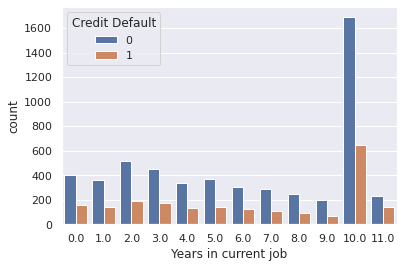

In [961]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.show()

###Number of Open Accounts

In [962]:
df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

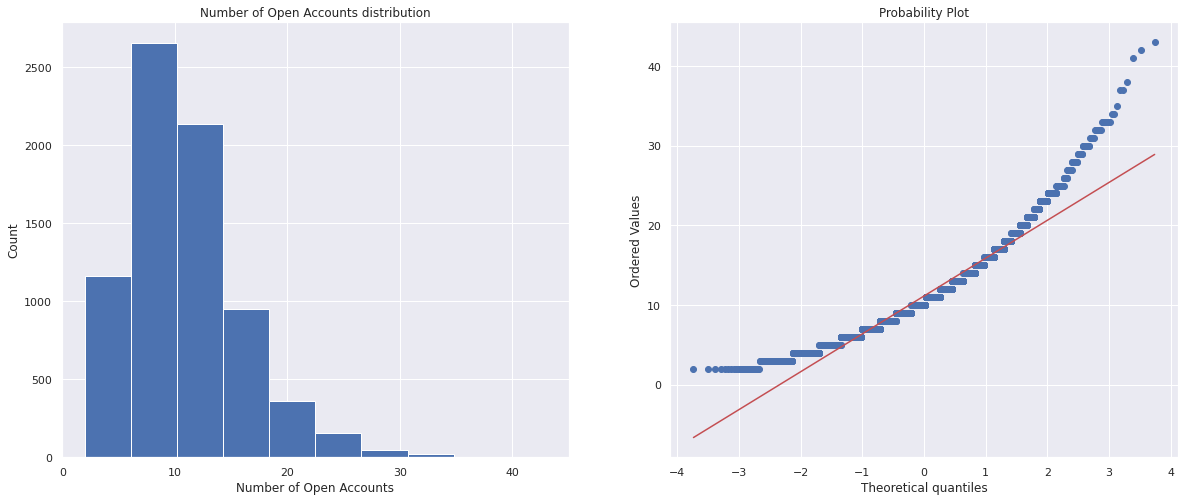

In [963]:
describe_tables('Number of Open Accounts')


In [964]:
df = outlier_cutter(df, 'Number of Open Accounts')
df_test = outlier_cutter(df_test, 'Number of Open Accounts')

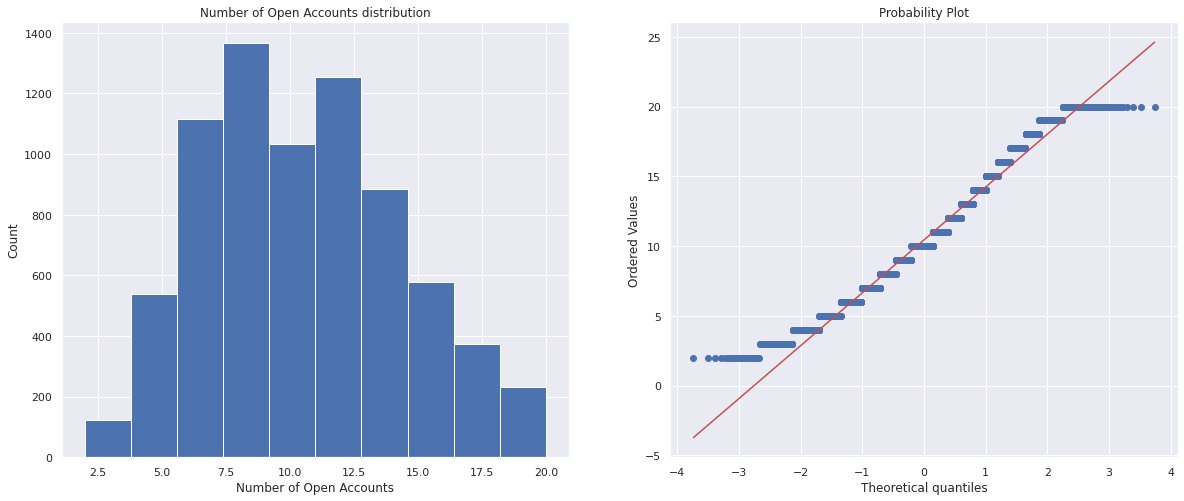

In [965]:
describe_tables('Number of Open Accounts')

###Years of Credit History

In [966]:
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

In [967]:
df = years_of_credit_history(df)
df_test = years_of_credit_history(df_test)

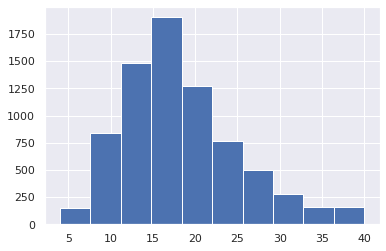

In [968]:
df['Years of Credit History'].hist()

###Maximum Open Credit 

In [969]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

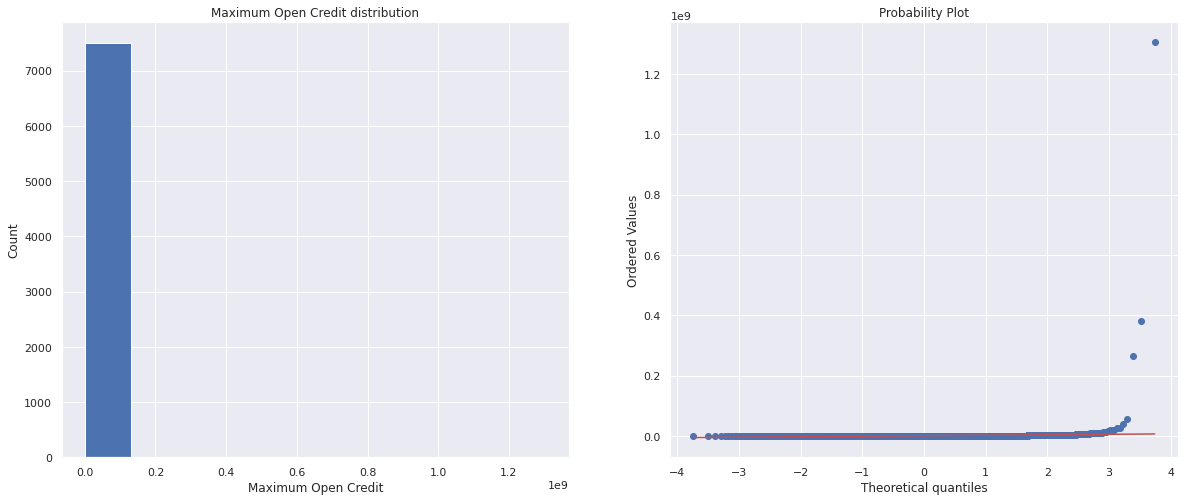

In [970]:
describe_tables('Maximum Open Credit')

In [971]:
df = outlier_cutter(df, 'Maximum Open Credit')
df_test = outlier_cutter(df_test, 'Maximum Open Credit')

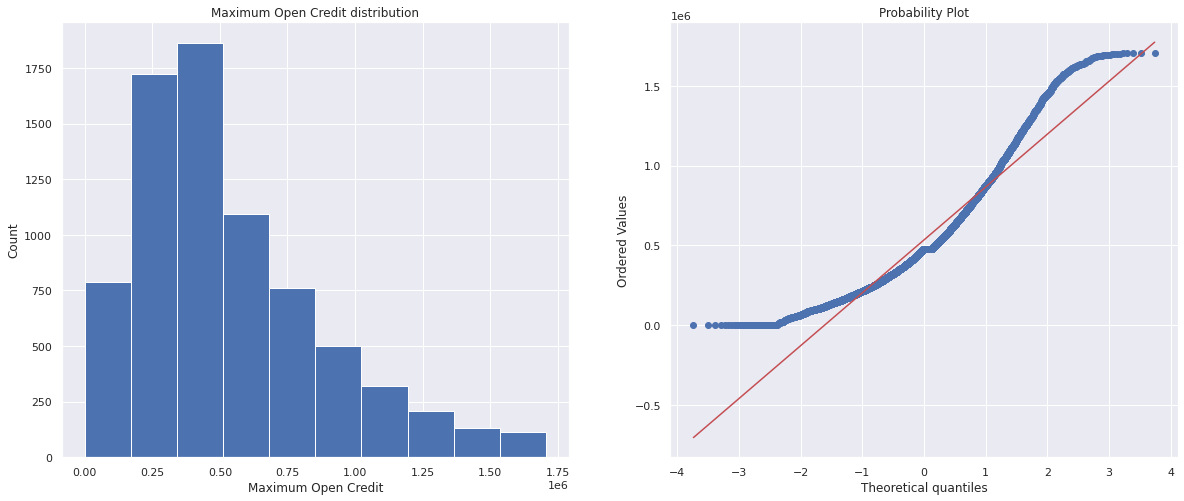

In [972]:
describe_tables('Maximum Open Credit')

###Bankruptcies

In [973]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [974]:
df = nan_filler(df, 'Bankruptcies')
df_test = nan_filler(df_test, 'Bankruptcies')

###Months since last delinquent

In [975]:
df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

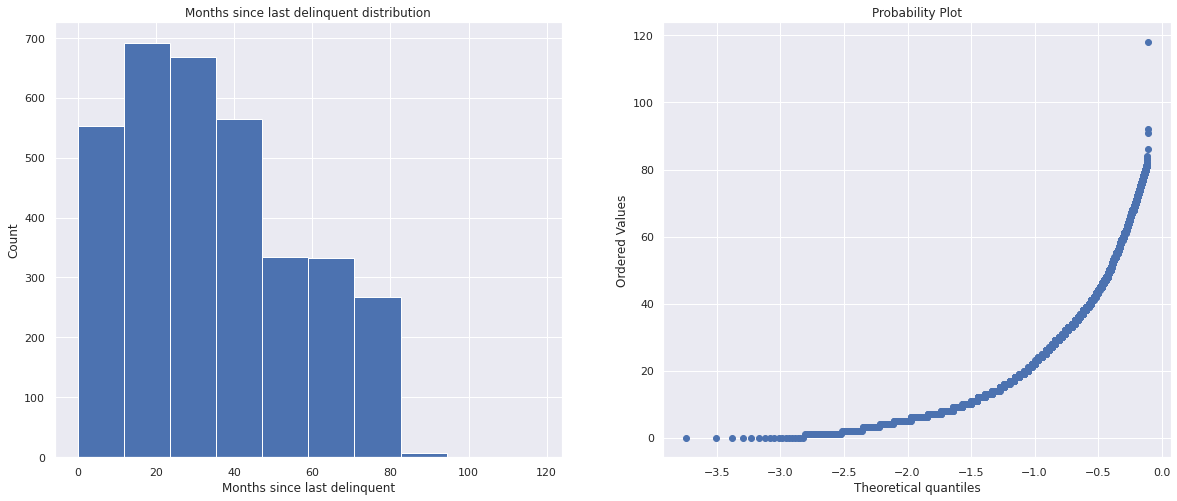

In [976]:
describe_tables('Months since last delinquent')

In [977]:
df = nan_filler(df, 'Months since last delinquent')
df_test = nan_filler(df_test, 'Months since last delinquent')

###Purpose 

In [978]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

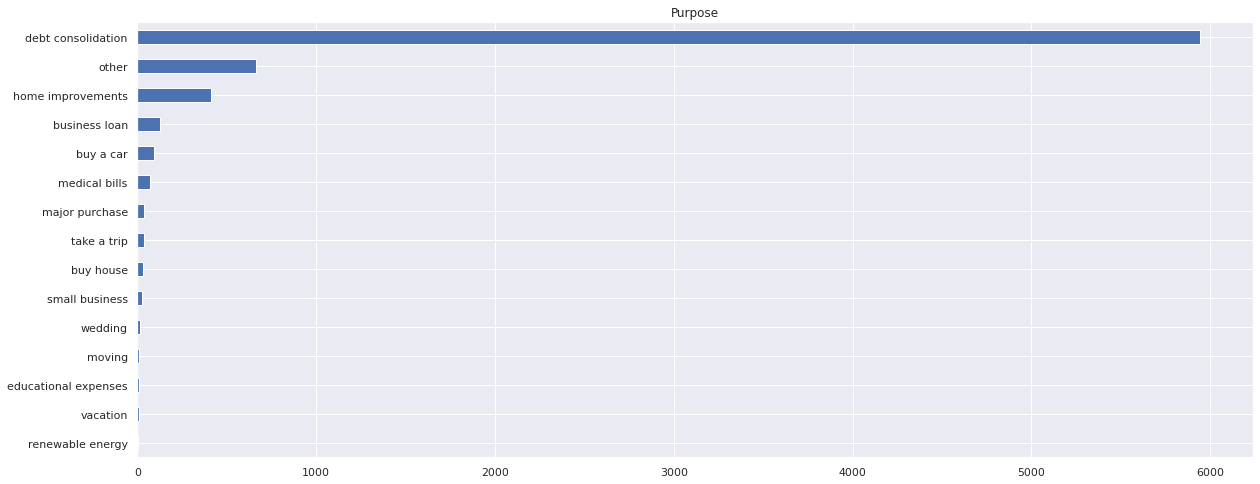

In [979]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(20,8))

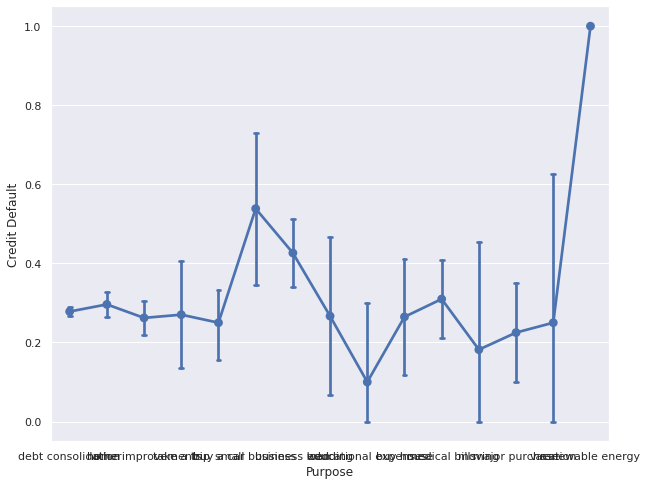

In [980]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [981]:
less_purposes = {'debt consolidation':'0', 'other':'0','home improvements':'0','business loan':'1',
                'buy a car':'0','medical bills':'0','major purchase':'0','take a trip':'0','buy house':'0',
                'small business':'2','wedding':'0','moving':'0','educational expenses':'3','vacation':'0',
                'renewable energy':'0'}

df = other_value_filler(df, 'Purpose', less_purposes, float)
df_test = other_value_filler(df_test, 'Purpose', less_purposes, float)

###Term

In [982]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [983]:
df = other_value_filler(df, 'Term', {'Short Term':'1', 'Long Term':'0'}, float)
df_test = other_value_filler(df_test, 'Term', {'Short Term':'1', 'Long Term':'0'}, float)

###Current Loan Amount

In [984]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

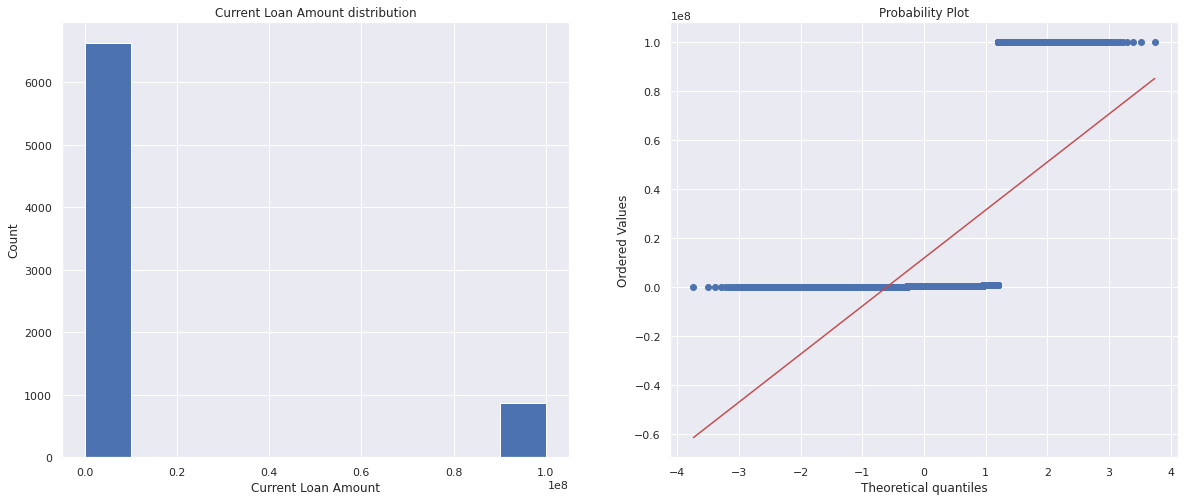

In [985]:
describe_tables('Current Loan Amount')

In [986]:
df = current_loan_amount(df)
df_test = current_loan_amount(df_test)

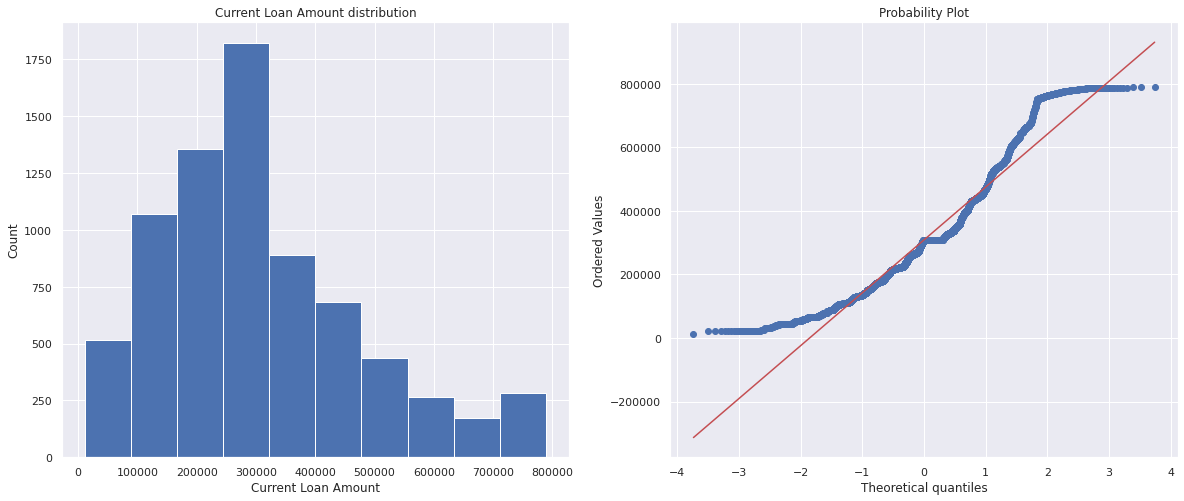

In [987]:
describe_tables('Current Loan Amount')

###Current Credit Balance

In [988]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

In [989]:
df = outlier_cutter(df, 'Current Credit Balance')
df_test = outlier_cutter(df_test, 'Current Credit Balance')


###Monthly Debt

In [990]:
df['Monthly Debt'].value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly Debt, Length: 6716, dtype: int64

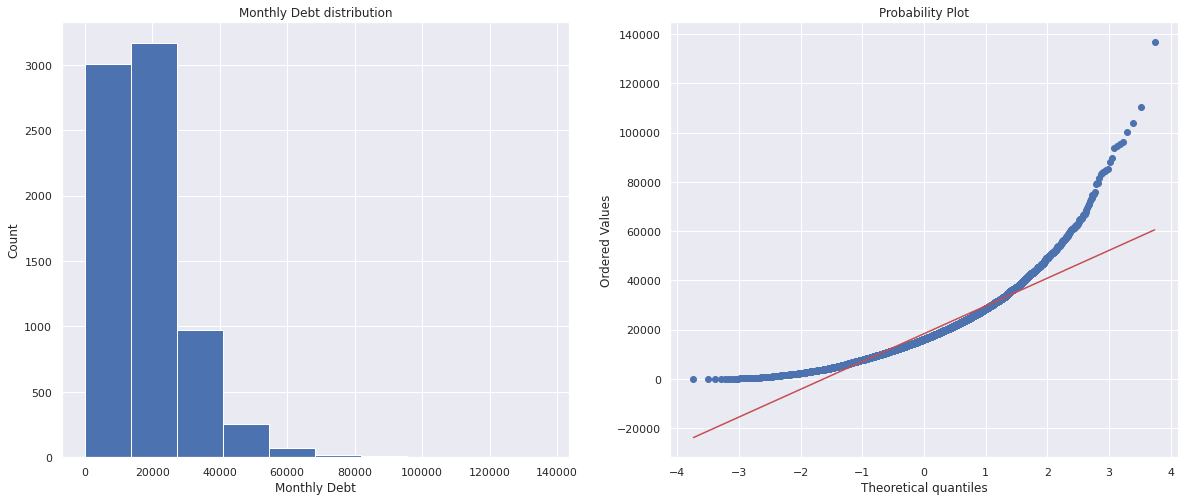

In [991]:
describe_tables('Monthly Debt')

In [992]:
df = outlier_cutter(df, 'Current Credit Balance', .99)
df_test = outlier_cutter(df_test, 'Current Credit Balance', .99)

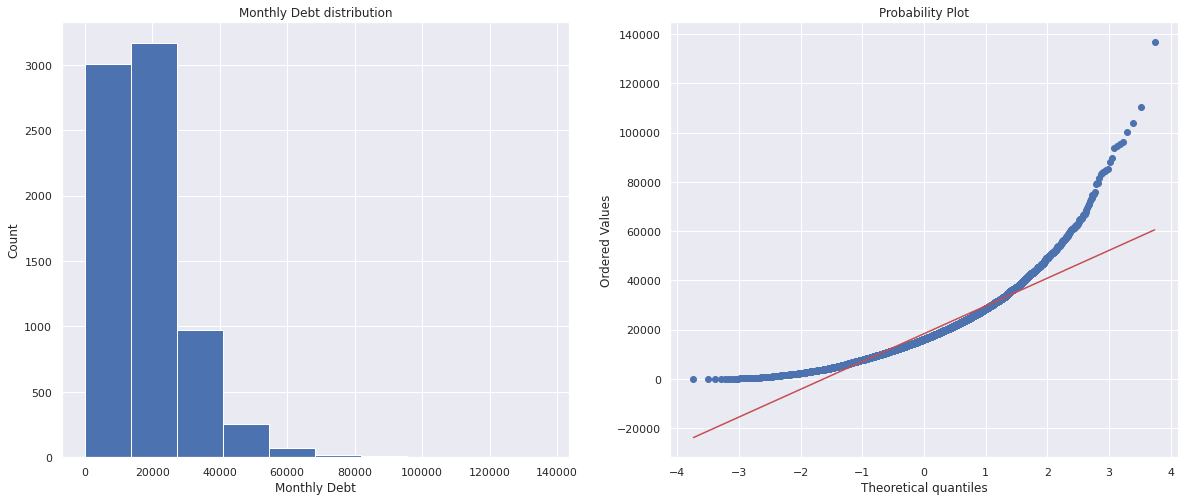

In [993]:
describe_tables('Monthly Debt')

###Credit Score

In [994]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [995]:
df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

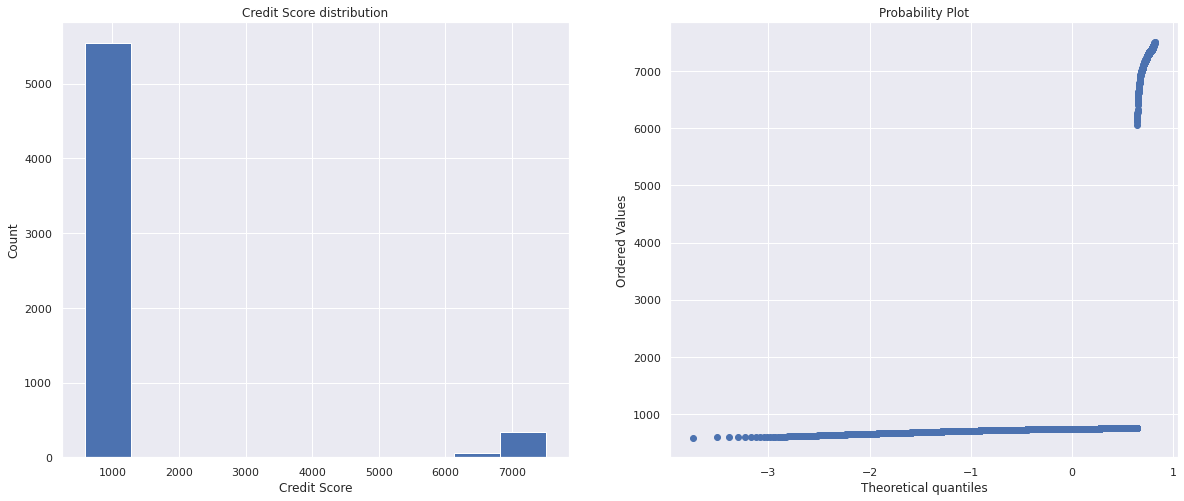

In [996]:
describe_tables('Credit Score')

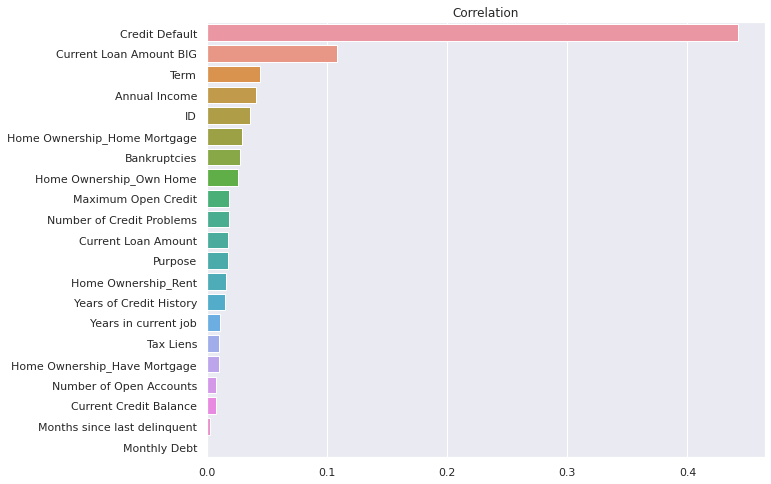

In [997]:
FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [998]:
TARGET_FEATURE = ['Current Loan Amount BIG','Current Loan Amount','Term','Annual Income',
                  'Home Ownership_Home Mortgage','Bankruptcies','Home Ownership_Own Home',
                  'Maximum Open Credit','Number of Credit Problems','Purpose','Home Ownership_Rent',
                  'Years of Credit History','Years in current job']

In [999]:
data = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]

In [1000]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount BIG       5943 non-null   bool   
 1   Current Loan Amount           5943 non-null   float64
 2   Term                          5943 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Bankruptcies                  5943 non-null   float64
 6   Home Ownership_Own Home       5943 non-null   uint8  
 7   Maximum Open Credit           5943 non-null   float64
 8   Number of Credit Problems     5943 non-null   float64
 9   Purpose                       5943 non-null   float64
 10  Home Ownership_Rent           5943 non-null   uint8  
 11  Years of Credit History       5943 non-null   float64
 12  Years in current job          5943 non-null   float64
 13  Cre

In [1001]:
%%time

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

CPU times: user 18.5 s, sys: 11.8 s, total: 30.3 s
Wall time: 16.7 s


In [1004]:
df.loc[(df['Credit Score'].isnull()), ['Credit Score']] = model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE])
df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] = model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

In [1005]:
df_test['Credit Score']

0        743.0
1        699.0
2       7260.0
3        739.0
4        706.0
         ...  
2495     745.0
2496     747.0
2497     695.0
2498     744.0
2499    6820.0
Name: Credit Score, Length: 2500, dtype: float64

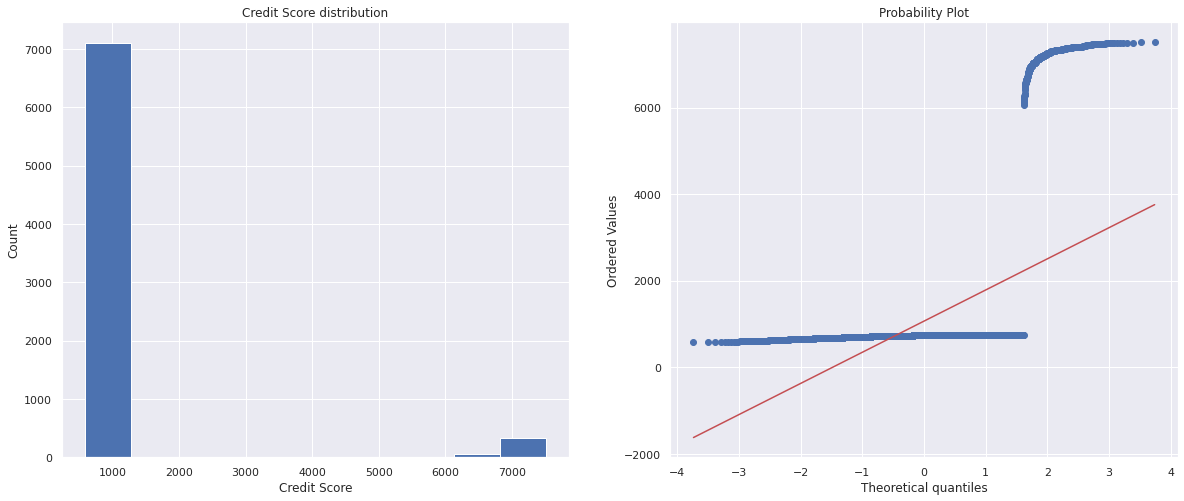

In [1006]:
describe_tables('Credit Score')

In [1007]:
df = credit_score(df)
df_test = credit_score(df_test)

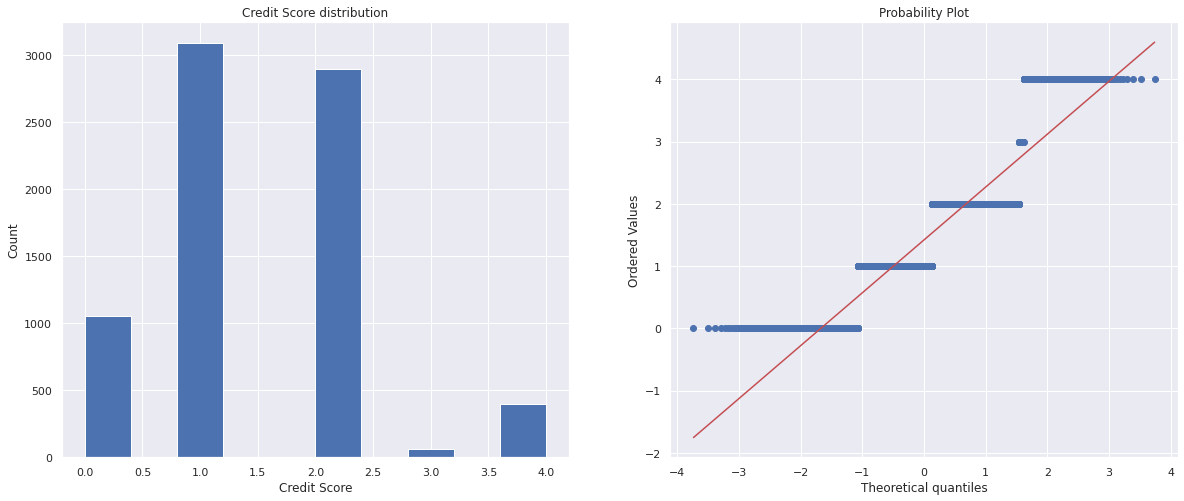

In [1008]:
describe_tables('Credit Score')

###New - No problems

In [1009]:
df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)
df_test['No problems'] = (df_test['Tax Liens'] == 0) & (df_test['Bankruptcies'] == 0) & (df_test['Number of Credit Problems'] == 0)

###Credit Default 

In [1010]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

##Итоги

In [1011]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Years in current job          7500 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Purpose                       7500 non-null   float64
 10  Term                          7500 non-null   float64
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [1012]:
COL_SELECTED = ['Current Loan Amount BIG','No problems','Annual Income','Years in current job',
                'Number of Open Accounts','Years of Credit History','Maximum Open Credit','Purpose',
                'Term','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score',
                'Home Ownership_Have Mortgage','Home Ownership_Home Mortgage','Home Ownership_Own Home',
                'Home Ownership_Rent']

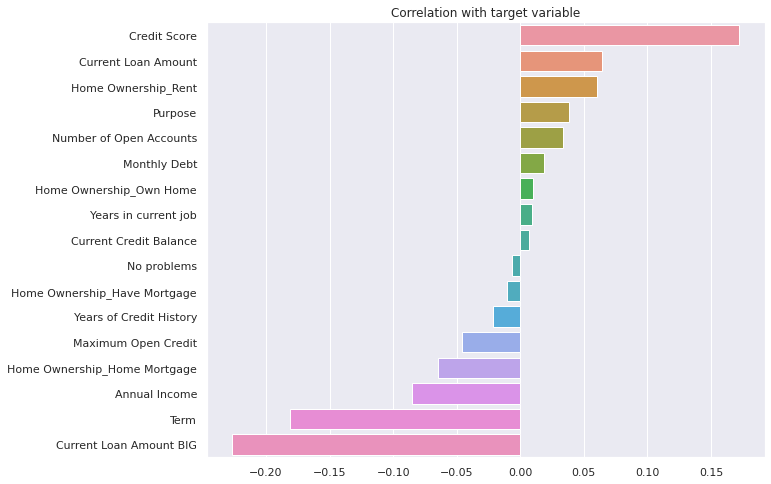

In [1013]:
corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

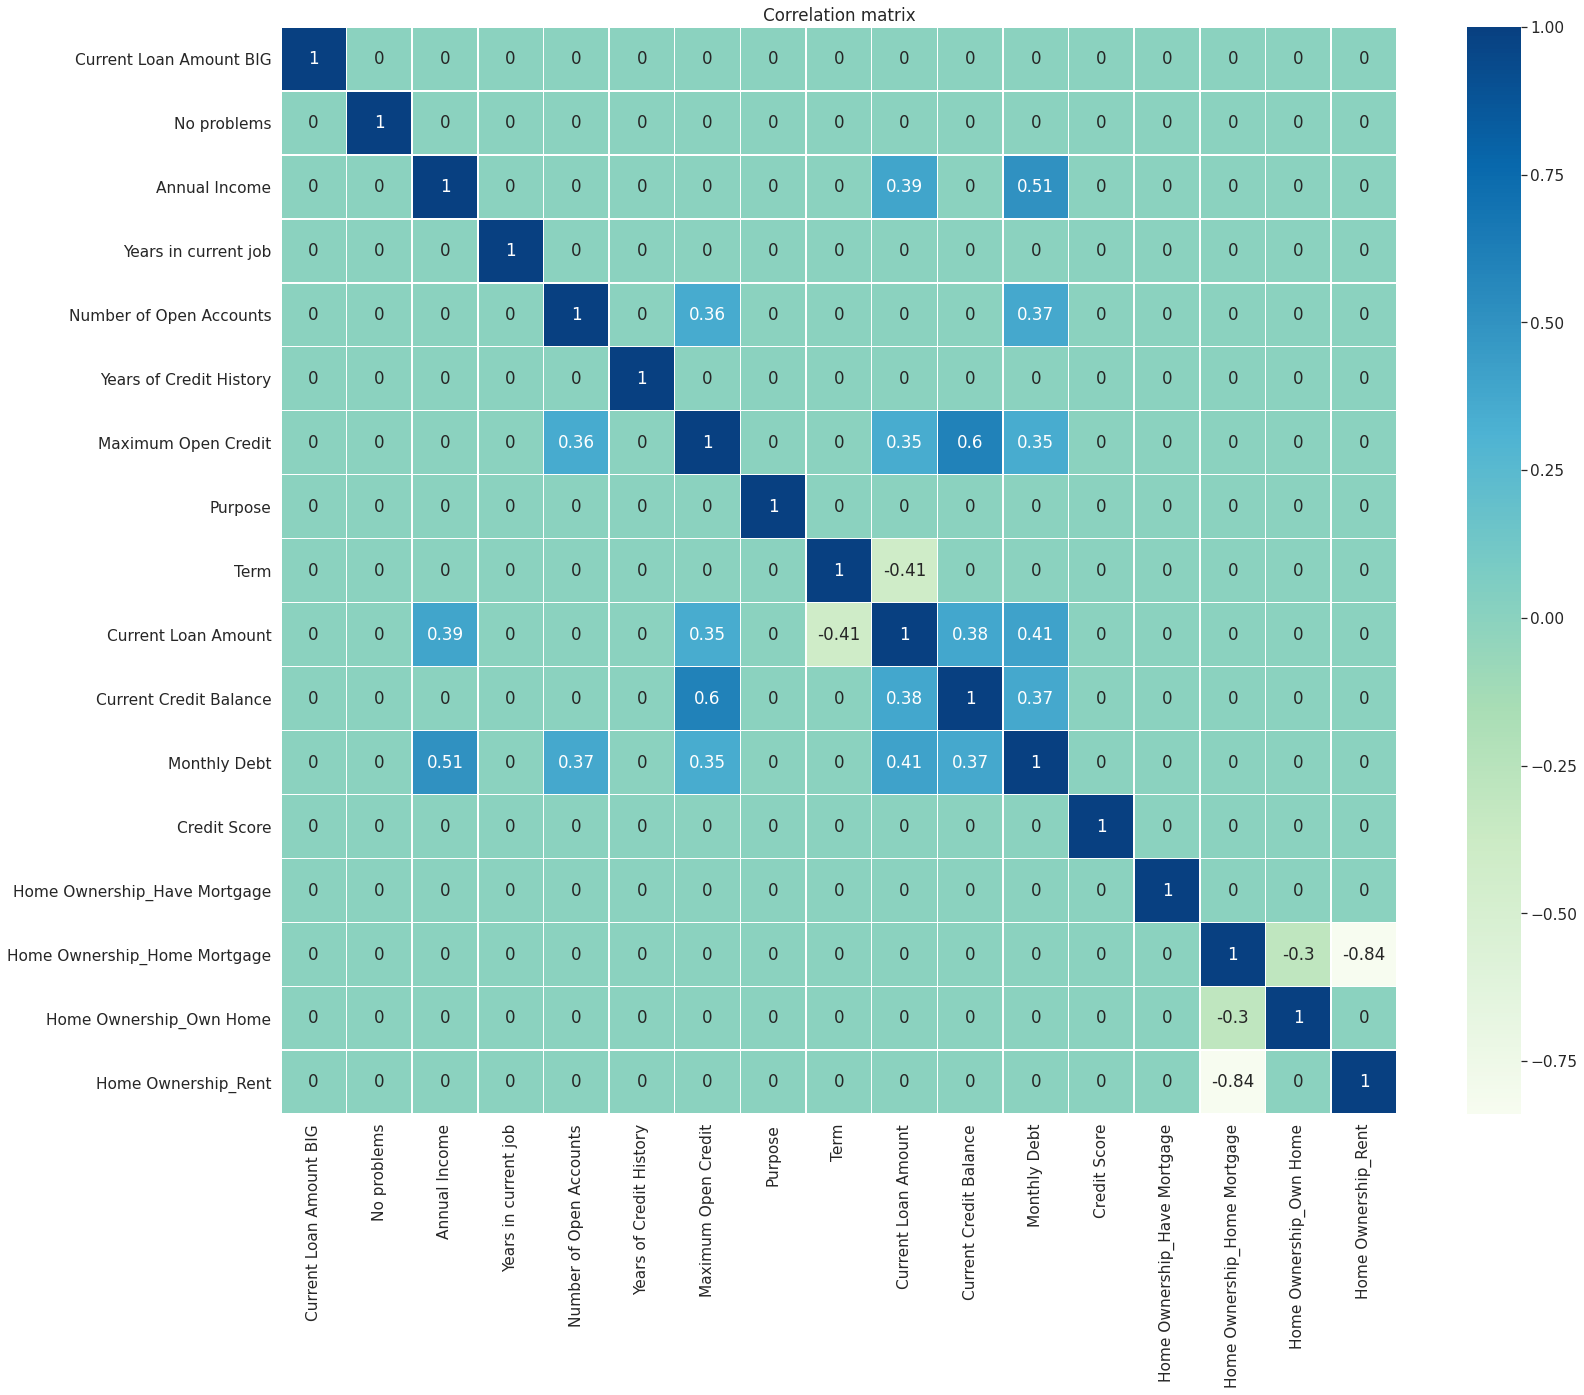

In [1014]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[COL_SELECTED].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

##Разбиваем на поезд и тест

In [1015]:
X = df[COL_SELECTED]
Y = df[TARGET_NAME]

In [1016]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=0.2, random_state=24)

## CatBoost

In [1017]:
%%time

model_cb = cb.CatBoostClassifier(class_weights=[1.08, 3], depth=4, iterations=490,  silent=True)

model_cb.fit(X_train, Y_train)

#Y_train_pred = model_cb.predict(X_train)
Y_test_pred = model_cb.predict(X_test)

CPU times: user 2.48 s, sys: 155 ms, total: 2.64 s
Wall time: 1.92 s


In [1018]:
f1_score(Y_test, Y_test_pred)

0.5873320537428022

## Заносим результаты

In [1019]:
def result_writer():
  result = pd.DataFrame(range(len(df_test)), columns=['ID'])
  result['Credit Default'] = model_cb.predict(df_test[COL_SELECTED])
  result.to_csv(r'/content/drive/MyDrive/project_data/EDEpishev_predictions.csv', index=False)

In [1020]:
# result_writer()
